In [1]:
import os
import glob
import itertools
import json
import importlib
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import dill as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import tifffile as tf

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils

In [3]:
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.retinotopy.utils as retutils
import analyze2p.extraction.rois as roiutils

In [4]:
%matplotlib notebook

In [5]:
# import allensdk as ak
import analyze2p.correlations as cr


# Plotting

In [6]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)

bw_colors = dict((v, [0.7]*3) for v in visual_areas)


# Source

In [291]:
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

response_type='dff'
experiment = 'blobs'
responsive_test='nstds'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
n_stds=2.5
n_bootstrap_iters=500
n_resamples=20
print(responsive_test, responsive_thr)

#### Responsive params
if experiment=='gratings':
    resp_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters, 
                            n_resamples=n_resamples)
else:
    resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)

data_id = '|'.join([traceid, resp_desc])
print(data_id)

nstds 10.0
traces001|dff_responsive-nstds-thr10.00


# Output dir

In [292]:
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       '%s_%s_%s' % (experiment, response_type, responsive_test))
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds


# Load metadata

In [293]:
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()
# all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]
CELLS = pd.concat([g for (va, dk), g in cells0.groupby(['visual_area', 'datakey'])\
                if not meta.query('@va == visual_area and @dk == datakey').empty])
print("[%s] dataset totals:" % experiment)         
print("FOVs:\n", CELLS[['visual_area', 'datakey']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())
print("CELLS:\n", CELLS[['visual_area', 'datakey', 'cell']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
[blobs] dataset totals:
FOVs:
 |    |   visual_area |
|:---|--------------:|
| Li |            19 |
| Lm |            18 |
| V1 |            16 |
CELLS:
 |    |   visual_area |
|:---|--------------:|
| Lm |          3382 |
| V1 |          3195 |
| Li |          2744 |


In [294]:
CELLS[CELLS.datakey=='20190615_JC097_fov2']

,cell,visual_area,animalid,session,fov,fovnum,datakey


# Load trial metrics

In [295]:
trial_epoch='stimulus' #'stimulus'
# NDATA0 = aggr.get_aggregate_data(experiment, traceid=traceid, 
#                       response_type=response_type, epoch=trial_epoch,
#                       responsive_test=responsive_test, verbose=False,
#                       responsive_thr=responsive_thr, n_stds=n_stds)
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 13 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]


In [296]:
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())


Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          2100 |
| Lm |          1987 |
| Li |          1197 |


# Load fits

In [297]:
import analyze2p.gratings.bootstrap_osi as osi

In [298]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [299]:
fit_thr=0.5
# if experiment == 'gratings':
#     gdata, no_fits, missing_ = osi.aggregate_ori_fits(CELLS, traceid=traceid, 
#                                 fit_desc=resp_desc, return_missing=True, 
#                                 verbose=False) 
#     # Get best GoF for each 
#     best_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
#                     .transform(max) == gdata['gof']
#     assert gdata.loc[best_ixs].groupby(['visual_area', 'datakey', 'cell'])\
#             .count().max().max()==1
#     bestg = gdata.loc[best_ixs].copy()
#     bestg = hutils.split_datakey(bestg)
#     counts = bestg[bestg['gof']>=fit_thr][['visual_area', 'datakey', 'cell']]\
#                         .drop_duplicates()\
#                         .groupby(['visual_area', 'datakey']).count().reset_index()
#     #counts = counts[counts['cell']>=min_ncells]
#     print("Missing GRATINGS fits for %i datasets" % len(missing_))
if experiment == 'rfs':
    # load fits, too
    do_spherical_correction=False
    rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                     do_spherical_correction=do_spherical_correction)
    rfdata = rfutils.aggregate_rfdata(meta, CELLS, fit_desc=rf_fit_desc,
                                     reliable_only=False)
    # Combined rfs5/rfs10 (V1/LM, default is 5-deg; LI, default is 10-deg)
    combined_rfs = rfutils.combine_rfs_single(rfdata) 
    #rfutils.average_rfs_select(rfdata)
    bestg = combined_rfs[combined_rfs['r2']>fit_thr].copy()
    counts = combined_rfs[['visual_area', 'datakey', 'cell']]\
                        .drop_duplicates()\
                        .groupby(['visual_area', 'datakey']).count().reset_index()
else:
    stim_datakeys = meta['datakey'].unique()
    SDF = aggr.check_sdfs(stim_datakeys, experiment=experiment,
                         return_incorrect=True, return_all=True)
    bestg = aggr.get_strongest_response(NDATA0)
    counts = CELLS.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
    counts = hutils.split_datakey(counts)

print("Cells, pre-filter")
print(bestg[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)

*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15.0 0.0], y: [-5.0 0.0]
Cells, pre-filter
|    |   visual_area |
|:---|--------------:|
| V1 |          2100 |
| Lm |          1987 |
| Li |          1197 |
[V1] Animalid does not exist: JC078 


In [300]:
# NDATA0[NDATA0.visual_area=='Li'][['visual_area', 'datakey', 'cell']]\
#     .drop_duplicates().groupby(['datakey']).count()

In [301]:
print(NDATA0[['visual_area', 'datakey', 'cell']]\
    .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |          2100 |
| Lm |          1987 |
| Li |          1197 |


#### Filter fits

In [302]:
# Drop repeat FOVs based on N fits
if experiment=='rfs':
    print('rfs')
    # RFs may have 2 experiments (duplicate)
    ucombined = pd.concat([g for (va, dk), g \
                                in bestg.groupby(['visual_area', 'datakey'])
                                if (va, dk) in u_dkeys])
    assert 'experiment' in NDATA0.columns
    NDATA = pd.concat([NDATA0.query(\
                    '@va==visual_area and @dk==datakey and @exp==experiment') \
                    for (va, dk, exp), g \
                    in ucombined.groupby(['visual_area', 'datakey', 'experiment'])])
else:
    NDATA = pd.concat([g for (va, dk), g in NDATA0.groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
    if 'experiment' not in NDATA.columns:
        NDATA['experiment'] = experiment

print("All the data (N cells):")
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
print("UNIQUE datasets (N cells):")
print(NDATA[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())

All the data (N cells):
|    |   visual_area |
|:---|--------------:|
| V1 |          2100 |
| Lm |          1987 |
| Li |          1197 |
UNIQUE datasets (N cells):
|    |   visual_area |
|:---|--------------:|
| V1 |          1662 |
| Lm |          1294 |
| Li |           833 |


In [303]:
print(NDATA[['visual_area', 'datakey']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| Li |            14 |
| Lm |            12 |
| V1 |             9 |


In [304]:
gdata_u = pd.concat([g for (va, dk), g in bestg.groupby(['visual_area', 'datakey'])
                if (va, dk) in u_dkeys])
print("Fit, unique FOV cell counts:")
print(gdata_u['visual_area'].value_counts().to_markdown())

if experiment in ['rfs']: #['gratings', 'rfs']:
    fit_thr=0.5
    thr_param = 'r2' if experiment=='rfs' else 'gof' #'gof'
    final_dkeys = [u[1] for u in u_dkeys]
    final_fits = bestg[(bestg[thr_param]>=fit_thr) 
                     & (bestg.datakey.isin(final_dkeys))].copy()
    print("GOOD fits (%s>=%.2f), unique cell counts:" % (thr_param, fit_thr))
    print(final_fits['visual_area'].value_counts().to_markdown())

Fit, unique FOV cell counts:
|    |   visual_area |
|:---|--------------:|
| V1 |          1662 |
| Lm |          1294 |
| Li |           833 |


In [305]:
NDATA[NDATA.datakey=='20191004_JC110_fov2']['experiment'].unique()

array([], dtype=object)

# Example FOV & CELL

In [306]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [71]:
va = 'V1'
dk='20190617_JC097_fov1'
selective_only=False

ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# Select cells
if selective_only:
    curr_cells = gdata_u[(gdata_u.visual_area==va) 
                    & (gdata_u.datakey==dk)]['cell'].unique()
    if len(curr_cells)<5:
        print("Skipping.")
else:
    curr_cells = ndf['cell'].unique()
# Select stimuli and trials
sdf = aggr.get_stimuli(dk, experiment=experiment)
curr_cfgs = sdf.index.tolist()
# corrs, zscored = cr.calculate_corrs(ndf, return_zscored=True,
#                                  curr_cells=curr_cells, curr_cfgs=curr_cfgs)
ccdist, zscored = cr.get_ccdist(ndf, return_zscored=True,
                                 curr_cells=curr_cells, curr_cfgs=curr_cfgs)

In [59]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

#### Representational Similarity Matrix

In [60]:
params = cr.get_key_stimulus_params(experiment)
tuning_ = cr.trial_averaged_responses(zscored, sdf, params=params)
rois_ = [i for i in tuning_.columns if hutils.isnumber(i)]

<IPython.core.display.Javascript object>


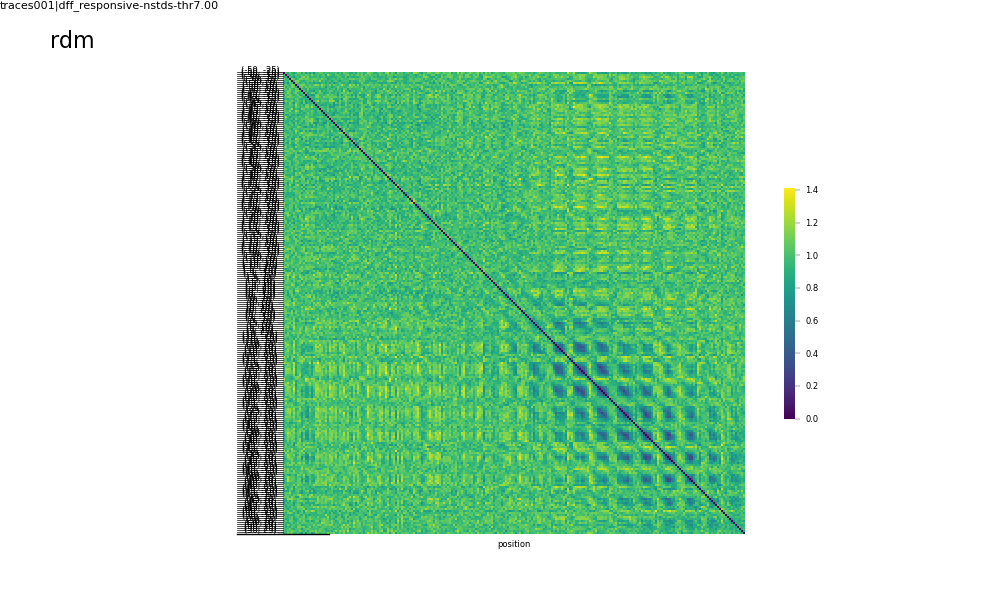

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds rdm__EXAMPLE_20190617_JC097_fov1


In [66]:
%matplotlib notebook
plot_rdm = True
plot_name = 'rdm' if plot_rdm else 'corr'

mat_, msk_, xlabels =  cr.get_correlation_matrix(tuning_, sdf,
                            experiment=experiment)

fig, ax = pl.subplots(1,1,figsize=(10, 6))
ax = cr.plot_correlation_matrix(mat_, plot_rdm=plot_rdm, ax=ax,
                            vmin=None, vmax=None)
fig.text(0.05, 0.92, plot_name, fontsize=16)

pplot.label_figure(fig, data_id)

figname = '%s__EXAMPLE_%s' % (plot_name, dk)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


In [65]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds'

#### Correlations

<IPython.core.display.Javascript object>


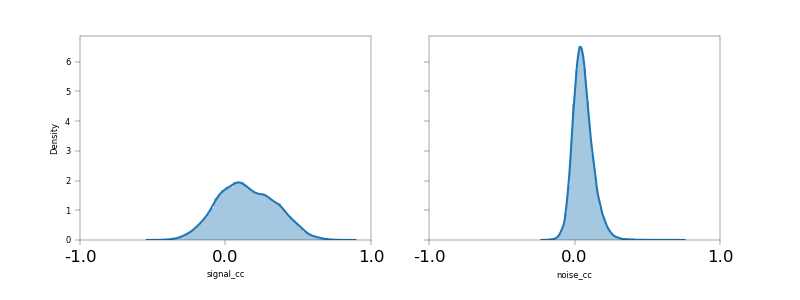

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


In [67]:
fig, axn = pl.subplots(1,2, figsize=(8,3), sharex=True, sharey=True)
sns.distplot(corrs['signal_cc'], ax=axn[0])
sns.distplot(corrs['noise_cc'], ax=axn[1])
for ax in axn.flat:
    ax.set_xlim([-1, 1])
    ax.set_xticks(np.linspace(-1, 1, 3))
    ax.set_xticklabels(np.linspace(-1, 1, 3), fontsize=12)
pl.subplots_adjust(bottom=0.2, left=0.1)

### Signal corrs. vs. Cortical distance

#### Load spatial info

In [326]:
# session, animalid, fovnum = hutils.split_datakey_str(dk)
# fov = 'FOV%i_zoom2p0x' % fovnum

# # Position info
# rois_ = ndf['cell'].unique()
# fcoords = roiutils.get_roi_coords(animalid, session, fov, traceid=traceid)
# pos_ = fcoords['roi_positions'].loc[rois_].copy()

In [68]:
# # Add cortical distances
# cc_ = corrs.copy()
# cc_ = cr.get_pw_cortical_distance(cc_, pos_)
# cc_['visual_area'] = va
# cc_['datakey'] = dk
# cc_.head()

In [328]:
importlib.reload(cr)
%matplotlib notebook

In [72]:
# Binning params
n_bins=4
use_quartile=True
custom_bins=False
cmap='viridis'
qcolor_list = sns.color_palette(cmap, n_colors=n_bins)
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)


| binned_cortical_distance   |   cortical_distance |   signal_cc |
|:---------------------------|--------------------:|------------:|
| 1st                        |             160.484 |   0.188009  |
| 2nd                        |             328.105 |   0.168662  |
| 3rd                        |             477.695 |   0.134745  |
| 4th                        |             719.332 |   0.0970089 |


<IPython.core.display.Javascript object>


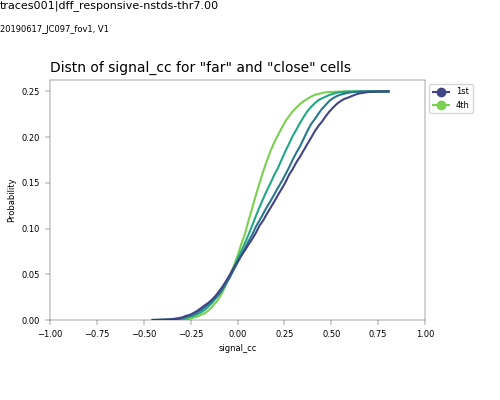

First and Last ~cortical_distance~ quartiles, diff <signal_cc> = nan


Text(0.0, 1.0, 'Distn of signal_cc for "far" and "close" cells')

In [78]:
metric = 'signal_cc'
bcorrs, bins_ = cr.bin_column_values(ccdist, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())

fig, ax = pl.subplots(figsize=(5,4))
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                    bin_labels=bin_labels, bin_colors=bin_colors, ax=ax,
                    cumulative=True, element='poly', fill=False, 
                    plot_median=False, extrema_only=False, lw=5)
ax.set_title('%s' % (metric), loc='left', fontsize=12)
ax.set_xlim([-1, 1])
# legend
leg_h = pplot.custom_legend_markers(colors=[bin_colors[i] for i in plot_bins],
                                   labels=plot_bins)
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper left')

# print some stuff
lo_median = ccdist[ccdist['binned_%s' % to_quartile]==0][metric].median()
hi_median = ccdist[ccdist['binned_%s' % to_quartile]==3][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8, right=0.85)

pplot.label_figure(fig, data_id)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "far" and "close" cells' % metric, \
                    loc='left', fontsize=10)

#### Receptive fields?

In [82]:
# RF info
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
rfs_ = combined_rfs[(combined_rfs.visual_area==va) & (combined_rfs.datakey==dk)
                   & (combined_rfs['cell'].isin(rois_))].copy()
rfs_.index = rfs_['cell'].values
# Get rf overlaps
rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
overlaps_ = rfutils.get_rf_overlaps(rf_polys)
overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) for c1, c2 \
                            in overlaps_[['cell_1', 'cell_2']].values]
# merge RF and CC/distance data
has_both = np.intersect1d(overlaps_['neuron_pair'], ccdist['neuron_pair'])
ccrf = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
               ccdist[ccdist['neuron_pair'].isin(has_both)])

In [85]:
# Bin into quartiles
to_quartile='signal_cc'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(ccrf, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)

| binned_signal_cc   |   signal_cc |   area_overlap |
|:-------------------|------------:|---------------:|
| 1st                |    0.142452 |       0.267805 |
| 2nd                |    0.307437 |       0.396659 |
| 3rd                |    0.411999 |       0.51646  |
| 4th                |    0.540153 |       0.6297   |
First and Last ~signal_cc~ quartiles, diff <area_overlap> = 0.37


<IPython.core.display.Javascript object>


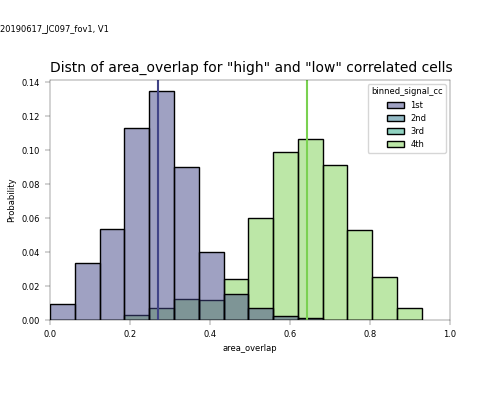

Text(0.0, 1.0, 'Distn of area_overlap for "high" and "low" correlated cells')

In [86]:
%matplotlib notebook
metric = 'area_overlap'
# print info
print(bcorrs.groupby(['binned_%s' % to_quartile])[[to_quartile, metric]]\
      .mean().to_markdown())
lo_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[0]][metric].median()
hi_median = bcorrs[bcorrs['binned_%s' % to_quartile]==bin_labels[-1]][metric].median()
print('First and Last ~%s~ quartiles, diff <%s> = %.2f' \
          % (to_quartile, metric, hi_median - lo_median))

# Plot metric X for top and bottom quartiles
fig, ax = pl.subplots(figsize=(5,4))
plot_bins = [bin_labels[0], bin_labels[-1]]
ax = cr.plot_quartile_dists_FOV(bcorrs, metric=metric, to_quartile=to_quartile,
                              bin_labels=bin_labels, bin_colors=bin_colors, ax=ax)
ax.set_xlim([0, 1])
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
fig.text(0.0, 0.92, '%s, %s' % (dk, va))
fig.axes[0].set_title('Distn of %s for "high" and "low" correlated cells'\
                    % metric, loc='left', fontsize=10)

# pplot.label_figure(fig, data_id)
# figname = '%s_Q_%s__EXAMPLE_%s' % (metric, to_quartile, dk)
# print(figname)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# Aggregate correlation metrics

In [25]:
# s_= []
# for (va, dk), g in meta.groupby(['visual_area', 'datakey']):
#     sdf = aggr.get_stimuli(dk, experiment='gratings')
#     sdf['visual_area'] = va
#     sdf['datakey'] = dk
#     s_.append(sdf)
# SD = pd.concat(s_, axis=0)

#### Select stimuli and calculate correlations
select_stimuli:  
    None (all stimuli), 
    'images' (apertured or blobs),
    'fullfield' (FF grating or morphlevel=-1)


In [307]:
importlib.reload(aggr)

<module 'analyze2p.aggregate_datasets' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py'>

In [308]:
# NDATA already contains only unique dkeys
CORRS=None
min_ncells=10
selective_only=False
select_stimuli = 'images'
# --------------------------------------------------------------------
wrong_configs=[]
c_list=[]
for (va, dk, exp), ndf in NDATA.groupby(['visual_area', 'datakey', 'experiment']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) & (gdata_u.datakey==dk) 
                      & (gdata_u.experiment==exp)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    curr_cfgs = aggr.select_stimulus_configs(dk, exp, select_stimuli=select_stimuli)
    if len(curr_cfgs)==0:
        wrong_configs.append((va, dk))
        continue
    cc_ = cr.get_ccdist(ndf, return_zscored=False,
                            curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    cc_['experiment'] = experiment
    cc_['n_cells'] = len(rois_)
    c_list.append(cc_)
CORRS = pd.concat(c_list)
print('%i datasets without configs:' % len(wrong_configs))
for w in wrong_configs:
    print("    %s" % str(w))

Skipping - (Li, 20190321_JC070_fov1)
Skipping - (Lm, 20191111_JC120_fov1)
0 datasets without configs:


In [309]:
CORRS['n_cells'].min()

12

In [310]:
# Check that dataset counts match
print(NDATA[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
      .value_counts().to_markdown())
print(CORRS[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
      .value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| Li |            14 |
| Lm |            12 |
| V1 |             9 |
|    |   visual_area |
|:---|--------------:|
| Li |            13 |
| Lm |            11 |
| V1 |             9 |


In [311]:
%matplotlib notebook

In [312]:
# ------------------------------
cmap='viridis'
custom_bins=False
use_quartile=True
# ------------------------------
n_iterations=500
n_samples=10
# ------------------------------

In [313]:
# Bin data
n_bins=10
to_quartile='cortical_distance'
metric='signal_cc'
# Bin 
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()
# Count N pairs in each bin
pairs_per_bin = bcorrs.groupby(['visual_area', 'binned_%s' % to_quartile])\
                ['neuron_pair'].count().reset_index()\
                .rename(columns={'neuron_pair': 'n_pairs'})

<IPython.core.display.Javascript object>


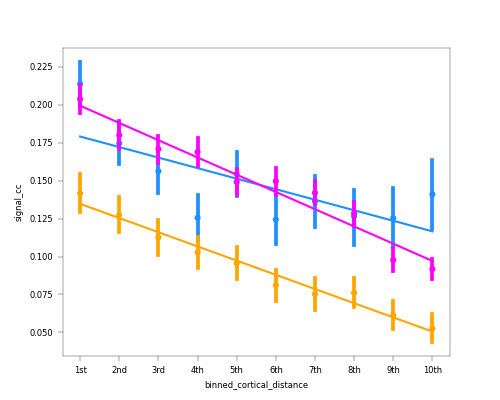

slope (95%): -0.006946 +/- 0.005220
intercept (95%): 0.179126 +/- 0.027866
slope (95%): -0.009362 +/- 0.001241
intercept (95%): 0.134749 +/- 0.006624
slope (95%): -0.011373 +/- 0.002085
intercept (95%): 0.199448 +/- 0.011129


In [314]:
fig, ax = pl.subplots()
for va, cc_ in bcorrs.groupby('visual_area'):
    sns.pointplot(x='binned_%s' % to_quartile, y='signal_cc', data=cc_, ax=ax,
             color=area_colors[va], scale=0.5, join=False)
    res, xdata, ydata = cr.linregress_on_binned(cc_, metric=metric,
                                            to_quartile=to_quartile, 
                                                return_inputs=True)
    tinv = lambda p, df: abs(spstats.t.ppf(p/2, df))
    ts = tinv(0.05, len(xdata)-2)
    print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
    print(f"intercept (95%): {res.intercept:.6f}"
          f" +/- {ts*res.intercept_stderr:.6f}")
    ax.plot(xdata, res.intercept + res.slope*xdata, 
            area_colors[va]) # label='fitted line')

In [315]:
# Fit function
resdf = cr.bootstrap_linregress(bcorrs, metric=metric, to_quartile=to_quartile,
                         n_iterations=n_iterations, n_samples=n_samples)

<IPython.core.display.Javascript object>


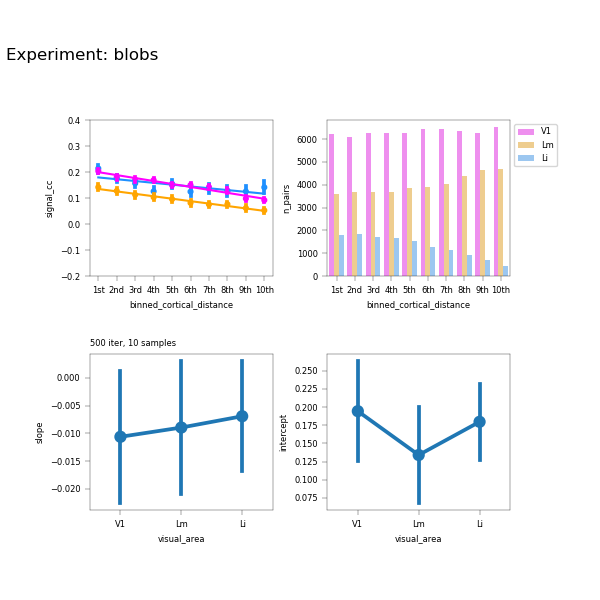

slope (95%): -0.006946 +/- 0.005220
intercept (95%): 0.179126 +/- 0.027866
slope (95%): -0.009362 +/- 0.001241
intercept (95%): 0.134749 +/- 0.006624
slope (95%): -0.011373 +/- 0.002085
intercept (95%): 0.199448 +/- 0.011129
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds linregress_signal_cc


In [320]:
# plot
fig, axn = pl.subplots(2,2, figsize=(6,6))
ax=axn[0,0]
for va, cc_ in bcorrs.groupby('visual_area'):
    sns.pointplot(x='binned_%s' % to_quartile, y='signal_cc', data=cc_, ax=ax,
             color=area_colors[va], scale=0.5, join=False)
    res, xdata, ydata = cr.linregress_on_binned(cc_, metric=metric,
                                            to_quartile=to_quartile, 
                                                return_inputs=True)
    tinv = lambda p, df: abs(spstats.t.ppf(p/2, df))
    ts = tinv(0.05, len(xdata)-2)
    print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
    print(f"intercept (95%): {res.intercept:.6f}"
          f" +/- {ts*res.intercept_stderr:.6f}")
    ax.plot(xdata, res.intercept + res.slope*xdata, 
            area_colors[va]) # label='fitted line')
    #x.set_ylim([-0.4,0.4])
    ax.set_ylim([-0.2, 0.4])
ax=axn[0, 1]
sns.barplot(x='binned_%s' % to_quartile, y='n_pairs', data=pairs_per_bin,
              hue='visual_area', ax=ax, palette=area_colors,
           hue_order=visual_areas, alpha=0.5)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')

ax=axn[1, 0]
sns.pointplot(x='visual_area', y='slope', data=resdf, ax=ax,
             ci='sd', order=visual_areas)
ax.set_title('%i iter, %i samples' % (n_iterations, n_samples), 
             loc='left', fontsize=6)
ax=axn[1,1]
sns.pointplot(x='visual_area', y='intercept', data=resdf, ax=ax,
             ci='sd', order=visual_areas)

fig.text(0.01, 0.9, 'Experiment: %s' % experiment, fontsize=12)
pl.subplots_adjust(bottom=0.15, right=0.85, left=0.15, wspace=0.3, top=0.8,
    hspace=0.5)

figname = 'linregress_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [240]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds'

<IPython.core.display.Javascript object>


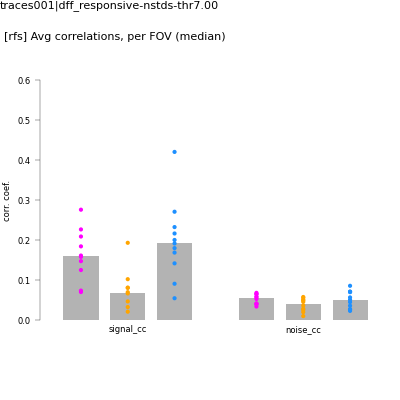

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/rfs_dff_nstds correlations_byfov_allcells


In [96]:
%matplotlib notebook
meancorrs = CORRS.groupby(['visual_area', 'datakey'])[['signal_cc', 'noise_cc']]\
                .mean() #.reset_index()
df_s = meancorrs.stack()\
    .rename_axis(index={'id': 'id', 'date': 'date', None: 'corr_type'})\
    .rename('corr_value').reset_index()

g = sns.FacetGrid(df_s, height=4)
g.map_dataframe(sns.stripplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=area_colors, 
                hue_order=visual_areas, dodge=True, size=3, jitter=False)
g.map_dataframe(sns.barplot, x="corr_type", y="corr_value", 
                hue="visual_area", palette=bw_colors, 
                estimator=np.median, #ci='sd',
                hue_order=visual_areas, dodge=True, errwidth=0)
pl.subplots_adjust(left=0.1, bottom=0.2, top=0.8)
pplot.change_width(g.fig.axes[0], 0.2)
sns.despine(bottom=True)
pl.ylim([0, 0.6])
g.fig.axes[0].tick_params(which='both', axis='x', size=0)
pl.ylabel('corr. coef.')
pplot.label_figure(g.fig, data_id)
g.fig.text(0.01, 0.9,'[%s] Avg correlations, per FOV (median)' \
           % experiment, fontsize=8)

plot_type = 'selectiveonly' if selective_only else 'allcells'
figname = 'correlations_byfov_%s' % plot_type
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Signal corrs for near vs. far cells

In [97]:
n_bins=4
custom_bins=False
cmap='viridis'
# ------------------------------
custom_bins=False
use_quartile=True
# Bin data
to_quartile='cortical_distance'
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CORRS, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
bcorrs = bcorrs.dropna()

<IPython.core.display.Javascript object>


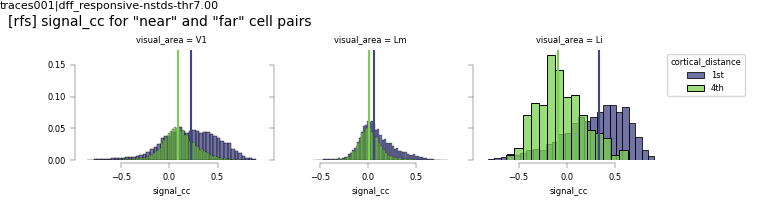

signal_cc_Q_cortical_distance_aggr


In [98]:
metric = 'signal_cc'
# Plot metric X for top and bottom quartiles
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric,
                        to_quartile=to_quartile)
sns.despine(trim=True, offset=2)
g.fig.text(0.01, 0.87, '[%s] %s for "near" and "far" cell pairs' \
           % (experiment, metric), fontsize=10)
# Save
pplot.label_figure(g.fig, data_id)
figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [198]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [136]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

<IPython.core.display.Javascript object>


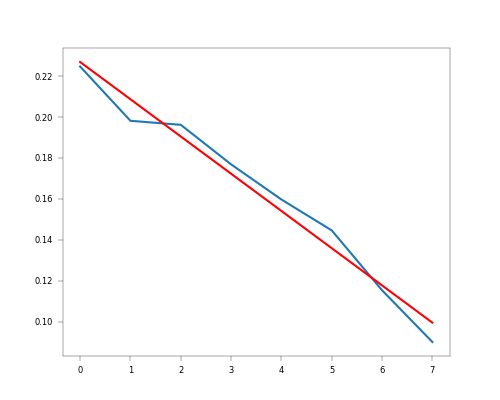

In [154]:
cc_=bcorrs[(bcorrs.visual_area==va)].copy()

metric='signal_cc'
xdata = np.array([i \
         for i, (xi, xg) in enumerate(cc_.groupby('binned_%s' % to_quartile))])
ydata = np.array([xg[metric].mean() \
         for xi, xg in cc_.groupby('binned_%s' % to_quartile)])

# popt, pcov = curve_fit(func, xdata, ydata)
res = spstats.linregress(xdata, ydata)
tinv = lambda p, df: abs(spstats.t.ppf(p/2, df))
ts = tinv(0.05, len(xdata)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")


pl.figure()
pl.plot(xdata, ydata)
pl.plot(xdata, res.intercept + res.slope*xdata, 'r', label='fitted line')

In [151]:
# popt, pcov = curve_fit(func, xdata, ydata)
res = spstats.linregress(xdata, ydata)
tinv = lambda p, df: abs(spstats.t.ppf(p/2, df))
ts = tinv(0.05, len(xdata)-2)
print(f"slope (95%): {res.slope:.6f} +/- {ts*res.stderr:.6f}")
print(f"intercept (95%): {res.intercept:.6f}"
      f" +/- {ts*res.intercept_stderr:.6f}")

slope, intercept, r, p, se = spstats.linregress(xdata, ydata)
print(slope, intercept)

slope (95%): -0.018206 +/- 0.002971
intercept (95%): 0.226896 +/- 0.012427
-0.018206090904754887 0.22689552969338084


#### by fov

<IPython.core.display.Javascript object>


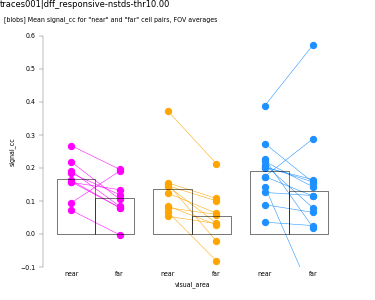

|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        7 |   0.074 | V1            |
|  1 |        0 |   0.002 | Lm            |
|  2 |       19 |   0.068 | Li            |
signal_cc_Q_cortical_distance_byFOV


In [32]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
# Only include if we have measures for all the bins
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey']) if len(fc)==len(bin_labels)])

plot_bins = [bin_labels[0], bin_labels[-1]]
currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()

fig, ax = pl.subplots()
metric='signal_cc'
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax, bar_ci=None,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  c1_label='near', c2_label='far',
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
ax.set_ylim([-0.1, 0.6])
fig.text(0.01, 0.93, '[%s] Mean %s for "near" and "far" cell pairs, FOV averages'\
        % (experiment, metric))
print(pstats.to_markdown())

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [33]:
for va, g in means_.groupby(['visual_area']):
    print(g[(g['binned_%s' % to_quartile].isin(['1st', '4th']))\
             ][['binned_%s'%to_quartile, 'datakey', 'signal_cc', 'n_cells']].to_markdown())

|     | binned_cortical_distance   | datakey             |   signal_cc |   n_cells |
|----:|:---------------------------|:--------------------|------------:|----------:|
|   1 | 1st                        | 20190315_JC070_fov1 |   0.21985   |        96 |
| 271 | 4th                        | 20190315_JC070_fov1 |   0.142124  |        96 |
|   2 | 1st                        | 20190316_JC070_fov1 |   0.204124  |        84 |
| 272 | 4th                        | 20190316_JC070_fov1 |   0.157268  |        84 |
|   3 | 1st                        | 20190319_JC067_fov1 |   0.389065  |        26 |
| 273 | 4th                        | 20190319_JC067_fov1 |   0.573747  |        26 |
|   5 | 1st                        | 20190321_JC070_fov1 |   0.174242  |        13 |
| 275 | 4th                        | 20190321_JC070_fov1 |   0.289355  |        13 |
|   6 | 1st                        | 20190322_JC073_fov1 |   0.274237  |       132 |
| 276 | 4th                        | 20190322_JC073_fov1 |   0.15

|    |   visual_area |
|:---|--------------:|
| Li |            14 |
| Lm |            11 |
| V1 |             9 |


<IPython.core.display.Javascript object>


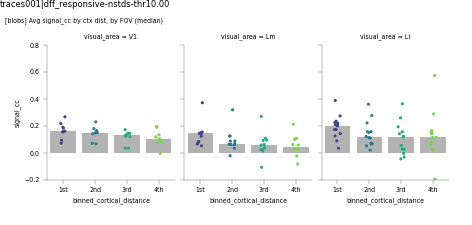

signal_cc_Q_cortical_distance_allbins_byFOV


In [34]:
dist_cmap = 'viridis'
print(fovmeans[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(fovmeans, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([-0.2, .8])

g.fig.text(0.01, 0.9, '[%s] Avg %s by ctx dist, by FOV (median)' \
           % (experiment, metric))
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [36]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in fovmeans.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in fovmeans.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 1.207, p value: 0.317
Name: Lm, F value: 2.163, p value: 0.108
Name: V1, F value: 2.122, p value: 0.117
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd  -0.0531 0.6388 -0.1751 0.0688  False
   1st    3rd  -0.0856 0.2712 -0.2099 0.0386  False
   1st    4th  -0.0616 0.5499 -0.1859 0.0626  False
   2nd    3rd  -0.0325 0.8952 -0.1567 0.0918  False
   2nd    4th  -0.0085    0.9 -0.1328 0.1157  False
   3rd    4th    0.024    0.9 -0.1026 0.1505  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd  -0.0454 0.5911 -0.1433 0.0524  False
   1st    3rd  -0.0759 0.1772 -0.1737  0.022  False
   1st    4th  -0.0852 0.1204 -0.1854 0.0151  False
   2nd    3rd  -0.0304 0.8189

# RF "similarity"

In [37]:
# Load RF data
do_spherical_correction=False
# Get cells and metadata
assigned_cells, rf_meta = aggr.select_assigned_cells(cells0, sdata, 
                                                experiments=['rfs', 'rfs10']) 
# Load RF fit data
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type, 
                                 do_spherical_correction=do_spherical_correction)
rfdata = rfutils.aggregate_rfdata(rf_meta, assigned_cells, fit_desc=rf_fit_desc,
                                 reliable_only=False)
# Combined rfs5/rfs10
combined_rfs = rfutils.combine_rfs_single(rfdata)

N dpaths: 62, N unfit: 0
N datasets included: 62, N sessions excluded: 4


In [38]:
print(combined_rfs[['visual_area', 'datakey', 'cell']]\
      .drop_duplicates().groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               436   436
Lm               405   405
V1               873   873


In [39]:
importlib.reload(rfutils)

<module 'analyze2p.receptive_fields.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/receptive_fields/utils.py'>

In [40]:
avg_rfs = rfutils.average_rfs(rfdata)

In [41]:
print(avg_rfs[['visual_area', 'datakey', 'cell']]\
      .drop_duplicates().groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li               450   450
Lm               422   422
V1              1090  1090


In [42]:
avg_rfs.shape, combined_rfs.shape

((1962, 28), (1714, 28))

In [43]:
# Get ROI positions
rfdf = aggr.add_roi_positions(avg_rfs)
rf_dkeys = [(va, dk) for (va, dk), g in rf_meta.groupby(['visual_area', 'datakey'])]
rfCELLS = pd.concat([g for (va, dk), g in \
                     assigned_cells.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in rf_dkeys])

Adding ROI position info...


#### Combine GDATA and RFDATA

In [44]:
%matplotlib notebook

In [45]:
strong_g = aggr.get_strongest_response(NDATA0)
print(strong_g[['visual_area', 'datakey', 'cell']].\
      drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |          2089 |
| Lm |          2032 |
| Li |          1247 |


In [46]:
print(bestg[['visual_area', 'datakey', 'cell']].\
      drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |          2089 |
| Lm |          2032 |
| Li |          1247 |


In [47]:
bestg['experiment'] = 'gratings'

In [48]:
rfdf[['visual_area', 'datakey', 'experiment']].drop_duplicates()\
.groupby(['visual_area', 'datakey']).max()

experiment
visual_area datakey                         
Li          20190522_JC089_fov1    ['rfs10']
            20190527_JC092_fov3    ['rfs10']
            20190528_JC092_fov1    ['rfs10']
            20190602_JC091_fov1  average_rfs
            20190606_JC091_fov1    ['rfs10']
            20190607_JC091_fov1    ['rfs10']
            20190609_JC099_fov1    ['rfs10']
            20190612_JC099_fov1    ['rfs10']
            20190614_JC091_fov1    ['rfs10']
            20190617_JC099_fov1    ['rfs10']
            20191012_JC113_fov1    ['rfs10']
            20191012_JC113_fov2    ['rfs10']
            20191017_JC113_fov1  average_rfs
            20191018_JC113_fov1    ['rfs10']
            20191105_JC117_fov1    ['rfs10']
            20191106_JC120_fov1    ['rfs10']
            20191111_JC120_fov1    ['rfs10']
Lm          20190423_JC076_fov1      ['rfs']
            20190430_JC078_fov1      ['rfs']
            20190504_JC078_fov1      ['rfs']
            20190506_JC080_fov1      ['rfs']
            20190508_JC083_fov1      ['rfs']
            20190509_JC078_fov1      ['rfs']
            20190512_JC083_fov1      ['rfs']
            20190513_JC078_fov1      ['rfs']
            20190517_JC083_fov1      ['rfs']
            20190525_JC084_fov1      ['rfs']
            20190602_JC080_fov2    ['rfs10']
            20190603_JC080_fov1      ['rfs']
            20190618_JC097_fov1  average_rfs
            20190627_JC091_fov1      ['rfs']
            20191111_JC117_fov1    ['rfs10']
            20191111_JC117_fov2    ['rfs10']
V1          20190420_JC076_fov1      ['rfs']
            20190501_JC076_fov1      ['rfs']
            20190504_JC078_fov1      ['rfs']
            20190507_JC083_fov1      ['rfs']
            20190508_JC083_fov1      ['rfs']
            20190509_JC078_fov1      ['rfs']
            20190510_JC083_fov1      ['rfs']
            20190511_JC083_fov1      ['rfs']
            20190512_JC083_fov1      ['rfs']
            20190517_JC083_fov1      ['rfs']
            20190522_JC084_fov1      ['rfs']
            20190613_JC097_fov1  average_rfs
            20190615_JC097_fov2    ['rfs10']
            20190616_JC097_fov1  average_rfs
            20190617_JC097_fov1      ['rfs']
            20190622_JC085_fov1  average_rfs
            20191004_JC110_fov2    ['rfs10']
            20191006_JC110_fov1  average_rfs
            20191111_JC117_fov1    ['rfs10']

In [49]:
# For each cell, get RF fit and EXP metric
# Use ALL data for both experiment types, then select unique later
RFS=[]; GFS=[];
for (va, dk, exp), gr_ in strong_g.groupby(['visual_area', 'datakey', 'experiment']):
    rfs_ = rfdf[(rfdf['visual_area']==va) 
              & (rfdf['datakey']==dk)].copy()
    if experiment=='rfs':
        rfs_ = rfs_[rfs_.experiment==exp]
    if len(rfs_)==0:
        continue
    common_cells = np.intersect1d(rfs_['cell'].unique(), gr_['cell'].unique())
    #print('%s: %i cells in common (%s)' % (va, len(common_cells), dk))
    RFS.append(rfs_[rfs_['cell'].isin(common_cells)])
    GFS.append(gr_[gr_['cell'].isin(common_cells)])
RFS = pd.concat(RFS, axis=0).reset_index(drop=True)
GFS = pd.concat(GFS, axis=0).reset_index(drop=True)
print(GFS.shape, RFS.shape)
cols_to_use = RFS.columns.difference(GFS.columns)
DF0 = pd.merge(GFS, RFS[cols_to_use], left_index=True, right_index=True, how='outer')
if experiment=='gratings':
    DF0['theta_deg'] = np.rad2deg(DF0['theta_Mm_c'])
    # Assign "preferred theta" for tested values
    theta_vals = np.linspace(0, 360, 9)

(1294, 7) (1294, 34)


In [50]:
counts = DF0.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
counts = hutils.split_datakey(counts)
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts)
DF = pd.concat([g for (va, dk), g in DF0.groupby(['visual_area', 'datakey'])\
                    if (va, dk) in u_dkeys])
print("N cells with both <%s> and RF fits:" % (experiment))
print(DF0.dropna()['visual_area'].value_counts().to_markdown())
print("--> w/ repeat FOVs removed (%s & RFs)" % experiment)
print(DF.dropna()['visual_area'].value_counts().to_markdown())

[V1] Animalid does not exist: JC078 
N cells with both <blobs> and RF fits:
|    |   visual_area |
|:---|--------------:|
| V1 |           766 |
| Lm |           332 |
| Li |           196 |
--> w/ repeat FOVs removed (blobs & RFs)
|    |   visual_area |
|:---|--------------:|
| V1 |           670 |
| Lm |           226 |
| Li |           134 |


In [51]:
print(DF[['visual_area', 'datakey', 'cell']].drop_duplicates()\
     .groupby(['visual_area', 'datakey']).count())

                                 cell
visual_area datakey                  
Li          20190602_JC091_fov1    61
            20190609_JC099_fov1    21
            20190614_JC091_fov1    40
            20190617_JC099_fov1     2
            20191018_JC113_fov1     6
            20191105_JC117_fov1     3
            20191111_JC120_fov1     1
Lm          20190430_JC078_fov1    33
            20190504_JC078_fov1     6
            20190508_JC083_fov1    64
            20190525_JC084_fov1    38
            20190603_JC080_fov1    54
            20190618_JC097_fov1    26
            20190627_JC091_fov1     5
V1          20190501_JC076_fov1     9
            20190507_JC083_fov1    56
            20190508_JC083_fov1     8
            20190522_JC084_fov1   109
            20190613_JC097_fov1    96
            20190616_JC097_fov1   137
            20190617_JC097_fov1    83
            20190622_JC085_fov1    89
            20191006_JC110_fov1    83


In [52]:
ndata_ccrf = pd.concat([g for (va, dk, exp), g in \
                NDATA0.groupby(['visual_area', 'datakey', 'experiment']) \
                if not DF\
                .query('@va==visual_area and @dk==datakey and @exp==experiment')\
                .empty])
# pd.concat([NDATA0[(NDATA0.visual_area==va)
#                         & (NDATA0.datakey==dk) & (NDATA0.experiment==exp)]\
#                          for (va, dk, exp), g in 
#                         DF.groupby(['visual_area', 'datakey', 'experiment'])])

print(ndata_ccrf[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())
print(DF[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Li |             7 |
| Lm |             7 |
|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Li |             7 |
| Lm |             7 |


In [53]:
#### Get cell position data
posdf_ccrf = ndata_ccrf[['visual_area', 'datakey', 'experiment', 'cell']].copy()\
        .drop_duplicates().reset_index(drop=True)
# Get ROI positions
posdf_ccrf = aggr.add_roi_positions(posdf_ccrf)

Adding ROI position info...


#### Calculate PW corrs for cells with RFs & experiment

In [54]:
#ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# NDATA already contains only unique dkeys
min_ncells=5
selective_only=False
select_stimuli='images'
c_list=[];
wrong_configs=[]
for (va, dk, exp), ndf in ndata_ccrf.groupby(['visual_area', 'datakey', 'experiment']):
    # Select cells
    if selective_only:
        rois_ = gdata_u[(gdata_u.visual_area==va) 
                        & (gdata_u.datakey==dk) 
                        & (gdata_u.experiment==exp)]['cell'].unique()
    else:
        rois_ = ndf['cell'].unique()
    if len(rois_)<min_ncells:
        print("Skipping - (%s, %s)" % (va, dk))
        continue
    # Select stimuli and trials
    curr_cfgs = aggr.select_stimulus_configs(dk, exp, select_stimuli=select_stimuli)
    if len(curr_cfgs)==0:
        wrong_configs.append((va, dk))
        continue
    cc_, zscored = cr.calculate_corrs(ndf, return_zscored=True,
                                     curr_cells=rois_, curr_cfgs=curr_cfgs)
    # Get position info for current dataset
    pos_ = posdf_ccrf[(posdf_ccrf.visual_area==va) 
                          & (posdf_ccrf.datakey==dk)].copy()
    if len(pos_)==0:
        print("No position info: %s" % dk)
        continue
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    cc_ = cr.get_pw_cortical_distance(cc_, pos_)
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    cc_['experiment'] = exp
    cc_['n_cells'] = len(rois_)
    c_list.append(cc_)
rfCORRS = pd.concat(c_list)
len(wrong_configs)

0

In [55]:
wrong_configs

[]

In [56]:
# Calculate RF overlap/similarity
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']
r_list=[]
for (va, dk), cc_ in rfCORRS.groupby(['visual_area', 'datakey']):
    rfs_ = rfdf[(rfdf.visual_area==va) 
                      & (rfdf.datakey==dk)].copy()
    if len(rfs_)<min_ncells:
        print("- skipping: %s, %s" % (va, dk))
        continue
    rfs_.index = rfs_['cell'].values
    # Get rf overlaps
    rf_polys = rfutils.rfs_to_polys(rfs_[rf_fit_params])
    overlaps_ = rfutils.get_rf_overlaps(rf_polys)
    overlaps_ = overlaps_.rename(columns={'poly1': 'cell_1', 'poly2': 'cell_2'})
    overlaps_['neuron_pair'] = ['%i_%i' % (c1, c2) \
                                for c1, c2 in overlaps_[['cell_1', 'cell_2']].values]
    # merge RF and CC/distance data
    has_both = np.intersect1d(overlaps_['neuron_pair'], cc_['neuron_pair'])
    ccrf_ = pd.merge(overlaps_[overlaps_['neuron_pair'].isin(has_both)],
                   cc_[cc_['neuron_pair'].isin(has_both)])
    # add RF position distances (coords of cell1 and cell2 in order)
    coords1 = np.array(rfs_.loc[ccrf_['cell_1'].values][['x0', 'y0']])
    coords2 = np.array(rfs_.loc[ccrf_['cell_2'].values][['x0', 'y0']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    ccrf_['rf_distance'] = dists
    # Add diff in RF orientation
    v1 = np.array(rfs_.loc[ccrf_['cell_1'].values]['theta_Mm_deg'].values)
    v2 = np.array(rfs_.loc[ccrf_['cell_2'].values]['theta_Mm_deg'].values)
    diffs = (v1-v2) % 90. #TODO Fix this 
    ccrf_['rf_orientation'] = diffs
    r_list.append(ccrf_)
CCRF = pd.concat(r_list, axis=0)

- skipping: Li, 20191111_JC120_fov1


In [57]:
(80- -80) % 90

70

In [58]:
(20 - (180-20)) % 90



40

In [321]:
vs = np.linspace(-90, 90, 20)
vs

array([-90.        , -80.52631579, -71.05263158, -61.57894737,
       -52.10526316, -42.63157895, -33.15789474, -23.68421053,
       -14.21052632,  -4.73684211,   4.73684211,  14.21052632,
        23.68421053,  33.15789474,  42.63157895,  52.10526316,
        61.57894737,  71.05263158,  80.52631579,  90.        ])

In [325]:
vs1 = np.array([180+v if v < 0 else v for v in vs])
vs1

array([ 90.        ,  99.47368421, 108.94736842, 118.42105263,
       127.89473684, 137.36842105, 146.84210526, 156.31578947,
       165.78947368, 175.26315789,   4.73684211,  14.21052632,
        23.68421053,  33.15789474,  42.63157895,  52.10526316,
        61.57894737,  71.05263158,  80.52631579,  90.        ])

In [340]:
vs1 =  np.array([180+v if v < 0 else v for v in vs])
vs1

array([ 90.        ,  99.47368421, 108.94736842, 118.42105263,
       127.89473684, 137.36842105, 146.84210526, 156.31578947,
       165.78947368, 175.26315789,   4.73684211,  14.21052632,
        23.68421053,  33.15789474,  42.63157895,  52.10526316,
        61.57894737,  71.05263158,  80.52631579,  90.        ])

In [339]:
vs-vs1

array([-180., -180., -180., -180., -180., -180., -180., -180., -180.,
       -180.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.])

In [347]:
180 -  (89 - -89)


2

In [352]:
180 - (91 - 0)


89

In [345]:
abs(np.sign(89)) 


1

In [59]:
print(CCRF[['visual_area', 'datakey']]\
      .drop_duplicates()['visual_area'].value_counts().to_markdown())

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             7 |
| Li |             6 |


|               |   area_overlap |   signal_cc |
|:--------------|---------------:|------------:|
| ('Li', '1st') |       0.215813 |  0.146902   |
| ('Li', '2nd') |       0.414162 |  0.319131   |
| ('Li', '3rd') |       0.539477 |  0.379723   |
| ('Li', '4th') |       0.69261  |  0.453162   |
| ('Lm', '1st') |       0.178139 |  0.00465596 |
| ('Lm', '2nd') |       0.406257 |  0.149174   |
| ('Lm', '3rd') |       0.539002 |  0.223113   |
| ('Lm', '4th') |       0.696377 |  0.28599    |
| ('V1', '1st') |       0.243373 |  0.112597   |
| ('V1', '2nd') |       0.415589 |  0.190317   |
| ('V1', '3rd') |       0.544871 |  0.262064   |
| ('V1', '4th') |       0.698751 |  0.334196   |


<IPython.core.display.Javascript object>


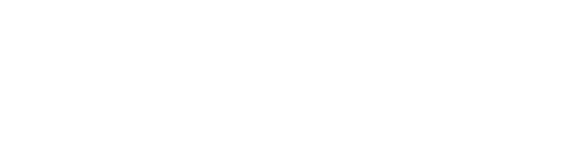

signal_ccQ_area_overlap_aggr


In [60]:
metric = 'signal_cc'
to_quartile='area_overlap'
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())
# PLot
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric, to_quartile=to_quartile, extrema_only=True)

g.fig.text(0.01, 0.87, '[%s] %s for "similar" and "different" RF shapes' \
           % (experiment, metric), fontsize=10)
pplot.label_figure(g.fig, data_id)
# Save
figname = '%sQ_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


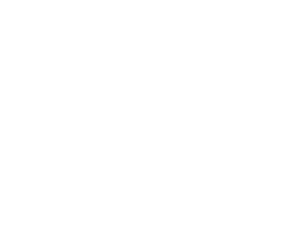

|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        0 |   0.004 | V1            |
|  1 |        0 |   0.062 | Lm            |
|  2 |        0 |   0.25  | Li            |
signal_cc_Q_area_overlap_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds


In [61]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
ax.set_ylim([-0.2, 0.8])
ax.set_xlabel('%s (percentile)' % to_quartile)
print(pstats.to_markdown())
fig.text(0.01, 0.92, \
        '[%s] Mean %s for "similar" and "different" RF shapes, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)
pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

In [62]:
%matplotlib notebook

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             7 |
| Li |             6 |


<IPython.core.display.Javascript object>


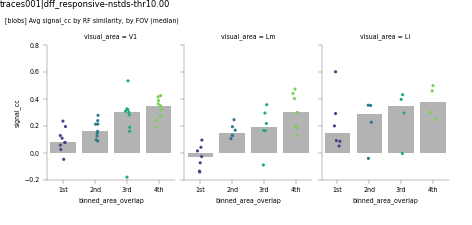

signal_cc_Q_area_overlap_allbins_byFOV


In [63]:
dist_cmap = 'viridis'
print(fovmeans[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(fovmeans, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([-0.2, .8])

g.fig.text(0.01, 0.9, '[%s] Avg %s by RF similarity, by FOV (median)' \
           % (experiment, metric))
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [64]:
print(fovmeans[['visual_area', 'binned_%s' % to_quartile, 'datakey']].drop_duplicates()\
      .groupby(['visual_area', 'binned_%s' % to_quartile]).count().to_markdown())


|               |   datakey |
|:--------------|----------:|
| ('Li', '1st') |         6 |
| ('Li', '2nd') |         4 |
| ('Li', '3rd') |         4 |
| ('Li', '4th') |         4 |
| ('Lm', '1st') |         7 |
| ('Lm', '2nd') |         6 |
| ('Lm', '3rd') |         6 |
| ('Lm', '4th') |         7 |
| ('V1', '1st') |         9 |
| ('V1', '2nd') |         9 |
| ('V1', '3rd') |         9 |
| ('V1', '4th') |         9 |


In [65]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in fovmeans.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in fovmeans.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 0.679, p value: 0.579
Name: Lm, F value: 10.156, p value: 0.000
Name: V1, F value: 6.576, p value: 0.001
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.0027    0.9 -0.3444 0.3498  False
   1st    3rd   0.0597    0.9 -0.2874 0.4068  False
   1st    4th   0.1566  0.566 -0.1905 0.5037  False
   2nd    3rd   0.0569    0.9 -0.3233 0.4372  False
   2nd    4th   0.1539 0.6384 -0.2264 0.5341  False
   3rd    4th   0.0969  0.872 -0.2833 0.4771  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   0.1945 0.0292  0.0162 0.3729   True
   1st    3rd   0.2173 0.0132   0.039 0.3957   True
   1st    4th    0.336  0.001  0.1647 0.5074   True
   2nd    3rd   0.0228    0.

# RF position

In [66]:
%matplotlib notebook

In [67]:
metric = 'signal_cc'
to_quartile='rf_distance'
custom_bins=False
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

|               |   rf_distance |   signal_cc |
|:--------------|--------------:|------------:|
| ('Li', '1st') |       2.946   |   0.465977  |
| ('Li', '2nd') |       6.51988 |   0.399906  |
| ('Li', '3rd') |      10.498   |   0.364622  |
| ('Li', '4th') |      25.9254  |   0.222927  |
| ('Lm', '1st') |       3.13192 |   0.288733  |
| ('Lm', '2nd') |       6.42804 |   0.273554  |
| ('Lm', '3rd') |      10.356   |   0.202154  |
| ('Lm', '4th') |      24.2521  |   0.0200058 |
| ('V1', '1st') |       2.97477 |   0.32948   |
| ('V1', '2nd') |       6.36764 |   0.260375  |
| ('V1', '3rd') |      10.0687  |   0.185955  |
| ('V1', '4th') |      16.233   |   0.0939741 |


<IPython.core.display.Javascript object>


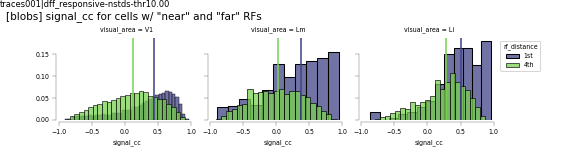

signal_cc_Q_rf_distance_aggr


In [68]:
g = cr.plot_quartile_dists_by_area(bcorrs, bin_labels, bin_colors,
                        metric=metric, to_quartile=to_quartile, extrema_only=True)

g.fig.text(0.01, 0.87, '[%s] %s for cells w/ "near" and "far" RFs' \
           % (experiment, metric), fontsize=10)
pplot.label_figure(g.fig, data_id)
# Save
figname = '%s_Q_%s_aggr' % (metric, to_quartile)
print(figname)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

<IPython.core.display.Javascript object>


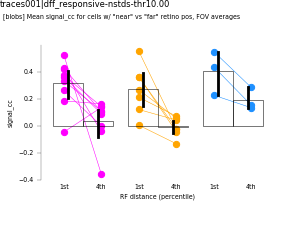

|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |        2 |   0.012 | V1            |
|  1 |        0 |   0.016 | Lm            |
|  2 |        0 |   0.25  | Li            |
signal_cc_Q_rf_distance_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_nstds


In [69]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
#ax.set_ylim([-0.2, 0.8])
print(pstats.to_markdown())
ax.set_xlabel('RF distance (percentile)')
fig.text(0.01, 0.92, \
        '[%s] Mean %s for cells w/ "near" vs "far" retino pos, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

|    |   visual_area |
|:---|--------------:|
| V1 |             9 |
| Lm |             7 |
| Li |             3 |


<IPython.core.display.Javascript object>


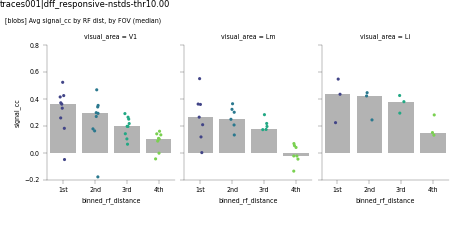

signal_cc_Q_rf_distance_allbins_byFOV


In [70]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([-0.2, .8])
g.fig.text(0.01, 0.9, '[%s] Avg %s by RF dist, by FOV (median)' \
           % (experiment, metric))
pplot.label_figure(g.fig, data_id)

figname = '%s_Q_%s_allbins_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname)

In [71]:
import scipy.stats as ss
from statsmodels.stats.multicomp import pairwise_tukeyhsd

for va, df_ in means_.groupby('visual_area'):
    samples = [b_df for b, b_df in df_.groupby('binned_%s' % to_quartile)[metric]]
    f_val, p_val = ss.f_oneway(*samples)
    print('Name: {}, F value: {:.3f}, p value: {:.3f}'.format(va, f_val, p_val))

for va, df_ in means_.groupby('visual_area'):
    print('Name {}'.format(va), 
          pairwise_tukeyhsd(df_[metric], df_['binned_%s' % to_quartile]))

Name: Li, F value: 2.268, p value: 0.158
Name: Lm, F value: 1.831, p value: 0.169
Name: V1, F value: 5.316, p value: 0.004
Name Li Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   -0.031    0.9 -0.3234 0.2613  False
   1st    3rd  -0.0353    0.9 -0.3276  0.257  False
   1st    4th  -0.2139 0.1669 -0.5063 0.0784  False
   2nd    3rd  -0.0043    0.9 -0.2966 0.2881  False
   2nd    4th  -0.1829 0.2628 -0.4753 0.1094  False
   3rd    4th  -0.1786 0.2792  -0.471 0.1137  False
---------------------------------------------------
Name Lm Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1st    2nd   -0.124 0.7362 -0.4699  0.222  False
   1st    3rd  -0.2158 0.3354 -0.5617 0.1301  False
   1st    4th  -0.2754  0.153 -0.6213 0.0705  False
   2nd    3rd  -0.0918 0.8767

## RF orientation 

In [189]:
metric = 'signal_cc'
to_quartile='rf_orientation'
custom_bins=False
n_bins=4
# Bin data
bins, bin_labels, bin_colors = cr.get_bins(n_bins=n_bins, custom_bins=custom_bins, 
                                        use_quartile=use_quartile, cmap=cmap)
bcorrs, bins_ = cr.bin_column_values(CCRF, to_quartile=to_quartile, 
                     use_quartile=use_quartile, return_bins=True,
                     n_bins=n_bins, bins=bins, labels=bin_labels)
print(bcorrs.groupby(['visual_area', 'binned_%s' \
                      % to_quartile])[[to_quartile, metric]].mean().to_markdown())

|               |   rf_orientation |   signal_cc |
|:--------------|-----------------:|------------:|
| ('Li', '1st') |          7.79813 |    0.2369   |
| ('Li', '2nd') |         33.4276  |    0.369531 |
| ('Li', '3rd') |         57.4445  |    0.252739 |
| ('Li', '4th') |         81.2687  |    0.31032  |
| ('Lm', '1st') |          9.37067 |    0.172754 |
| ('Lm', '2nd') |         32.8717  |    0.124875 |
| ('Lm', '3rd') |         57.507   |    0.135598 |
| ('Lm', '4th') |         80.5939  |    0.172201 |
| ('V1', '1st') |          9.83221 |    0.284204 |
| ('V1', '2nd') |         32.3775  |    0.297492 |
| ('V1', '3rd') |         57.6662  |    0.288154 |
| ('V1', '4th') |         79.7542  |    0.286664 |


<IPython.core.display.Javascript object>


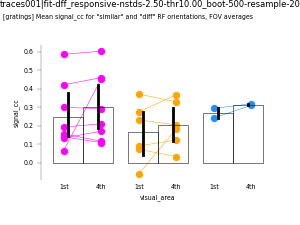

|    |   t_stat |   p_val | visual_area   |
|---:|---------:|--------:|:--------------|
|  0 |       12 |   0.461 | V1            |
|  1 |        8 |   0.688 | Lm            |
|  2 |        0 |   0.5   | Li            |
signal_cc_Q_rf_orientation_byFOV /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_nstds


In [190]:
fovmeans = bcorrs\
                .groupby(['binned_%s' % to_quartile, 'visual_area', 'datakey'])\
                .mean().reset_index().dropna()
means_ = pd.concat([fc for (va, dk), fc in fovmeans\
            .groupby(['visual_area', 'datakey'])if len(fc)==len(bin_labels)])

currd = means_[means_['binned_%s' % to_quartile].isin(plot_bins)].copy()
fig, ax = pl.subplots(figsize=(4,3))
ax, pstats = pplot.pairwise_compare_single_metric(currd, 
                  curr_metric=metric, ax=ax,
                  c1=plot_bins[0], c2=plot_bins[-1], 
                  compare_var='binned_%s' % to_quartile,
                  return_stats=True, ttest=False)
#ax.set_ylim([0, 1])
print(pstats.to_markdown())
fig.text(0.01, 0.92, \
        '[%s] Mean %s for "similar" and "diff" RF orientations, FOV averages' \
        % (experiment, metric))
pl.subplots_adjust(left=0.15, right=0.9, bottom=0.2, top=0.8)

pplot.label_figure(fig, data_id)
figname = '%s_Q_%s_byFOV' % (metric, to_quartile)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(figname, dst_dir)

|    |   visual_area |
|:---|--------------:|
| V1 |             8 |
| Lm |             6 |
| Li |             2 |


<IPython.core.display.Javascript object>


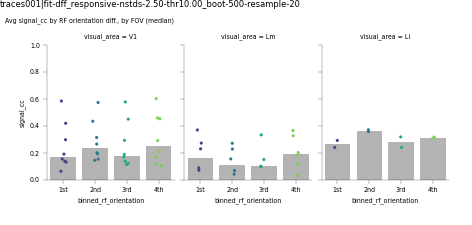

In [191]:
dist_cmap = 'viridis'
print(means_[['visual_area', 'datakey']].drop_duplicates()['visual_area']\
        .value_counts().to_markdown())
g = cr.plot_y_by_binned_x(means_, bin_labels, connect_fovs=False,cmap=dist_cmap,
                       metric=metric, to_quartile=to_quartile)
pl.ylim([0, 1.])
g.fig.text(0.01, 0.9, 'Avg %s by RF orientation diff., by FOV (median)' % metric)
pplot.label_figure(g.fig, data_id)


In [355]:
def theta_diff(t1, t2):
    
    def delta(x1, x2):
        return ((x1-x2)**2)**.5
    
    return min(delta(t1, t2) % 180, -delta(t1, t2) % 180)

In [363]:
t1=-2
t2=2
theta_diff(t1, t2)


4.0

# RF-RF metrics

In [239]:
# selective_only=False
# stimulus_type='allstim'

# assert stimulus_type in ['fullscreen', 'apertured', 'allstim']

# if stimulus_type=='fullscreen':
#     SD = fullSDF.copy()
# elif stimulus_type=='apertured':
#     SD = apSDF.copy()
# else:
#     SD = SDF.copy()
    
# roi_filter='gof%.2f' % gof_thr if selective_only else 'allcells'
# print(roi_filter)

In [471]:
min_ncells=5
selective_only=False
c_=[]
for (va, dk), ndf in NDATA.groupby(['visual_area', 'datakey']):
    # ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
    # Select cells
    if selective_only:
        curr_cells = passg[(passg.visual_area==va) 
                        & (passg.datakey==dk)]['cell'].unique()
    else:
        curr_cells = ndf['cell'].unique()
    if len(curr_cells)<min_ncells:
        continue
    # Select stimuli and trials
    sdf = aggr.get_stimuli(dk, experiment='gratings')
    curr_cfgs = sdf.index.tolist()
    cc_ = calculate_corrs(ndf, curr_cells=curr_cells, curr_cfgs=curr_cfgs)
    cc_['visual_area']=va
    cc_['datakey']=dk
    c_.append(cc_)
CC = pd.concat(c_, axis=0)


In [278]:
SDF={}
for (va, dk), g in NDATA.groupby(['visual_area', 'datakey']):
    sdf = p3.get_stimuli(dk, 'gratings')
    SDF[dk] = sdf

In [279]:
fullSDF = {}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']>50][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    fullSDF[dk] = subset #.append(subset)

In [280]:
apSDF={}
for dk, sdf in SDF.items():
    subset = sdf[sdf['size']<100][['ori', 'sf', 'size', 'speed']].copy()
    if len(subset)==0:
        print(dk)
    apSDF[dk] = subset #.append(subset)

20190522_JC089_fov1
20190527_JC092_fov3


In [472]:
c_ = []
for (va, dk), cc_ in CC.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    r1 = cc_['cell_1'].unique()
    r2 = cc_['cell_2'].unique()
    rois_ = np.union1d(r1, r2)
    pos_ = posdf[(posdf.visual_area==va) & (posdf.datakey==dk)].copy()
    assert len([r for r in rois_ if r not in pos_['cell'].values])==0, \
        "[%s, %s]: incorrect roi indexing in RFDATA" % (va, dk)
    pos_.index = pos_['cell'].values
    # Coords of cell1 in pair, in order
    coords1 = np.array(pos_.loc[cc_['cell_1'].values][['ml_pos', 'ap_pos']])
    # Coords of cell2 in pair 
    coords2 = np.array(pos_.loc[cc_['cell_2'].values][['ml_pos', 'ap_pos']])
    # Get dists, in order of appearance
    dists = [np.linalg.norm(c1-c2) for c1, c2 in zip(coords1, coords2)]
    cc_['cortical_distance'] = dists
    cc_['visual_area'] = va
    cc_['datakey'] = dk
    c_.append(cc_)
corrdist = pd.concat(c_, axis=0).reset_index(drop=True)


In [854]:
# Bin cortical distances for plotting
autosplit=False
if autosplit:
    n_bins_dist = 6
    use_quartile=False
    bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
    print("binning: %s" % bin_type)
    if use_quartile:
        corrdist['binned_dist'], bin_edges = pd.qcut(corrdist['cortical_distance'], \
                                        n_bins_dist, labels=False, retbins=True)
    else:
        corrdist['binned_dist'], bin_edges = pd.cut(corrdist['cortical_distance'], \
                                         n_bins_dist,labels=False, retbins=True)
else:
    bin_type='custombins'
    corrdist['binned_dist'] = pd.cut(x=corrdist['cortical_distance'], 
                                bins=[0, 100, 300, 500, np.inf], 
                                labels=['<100', '100-300', '300-500', '>500'])

mean_ccs = corrdist.groupby(['visual_area', 'datakey', 'binned_dist'])\
                        .mean().reset_index()

<IPython.core.display.Javascript object>


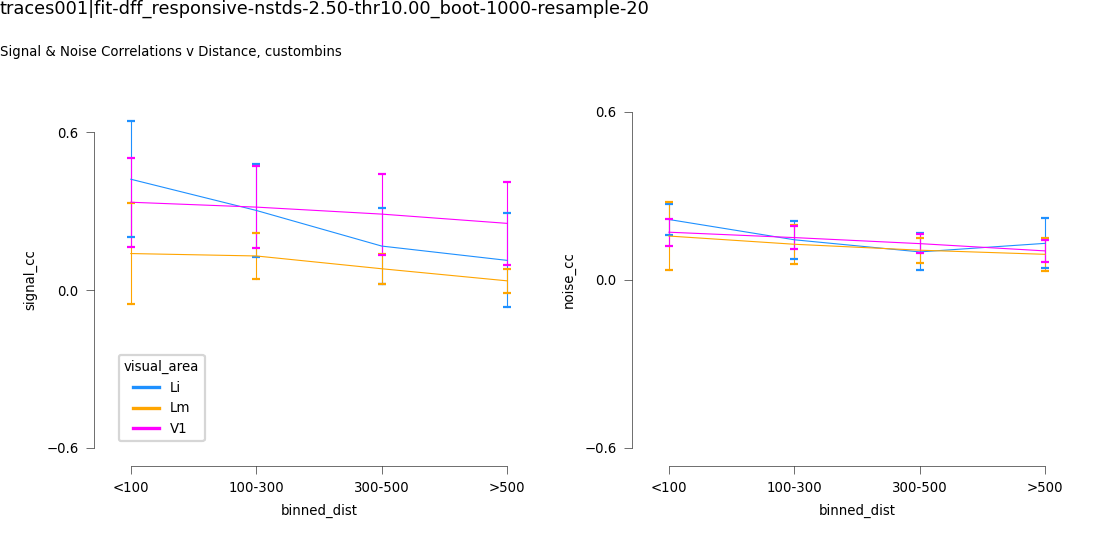

Text(0, 0.9, 'Signal & Noise Correlations v Distance, custombins')

In [855]:
lw=0.5

fig, axn = pl.subplots( 1, 2, figsize=(7,3.5)) #, sharex=True, sharey=False)
for ax, metric in zip(axn.flat, ['signal_cc', 'noise_cc']):
    sns.lineplot(x='binned_dist', y=metric, data=mean_ccs, ax=ax,
             hue='visual_area', palette=area_colors, ci='sd', err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)
    #ax.set_xticks(list(range(len(bin_edges))))
    #ax.set_xticklabels([round(i) for i in bin_edges])
    #ax.set_ylim([-0.7, 0.7])
    ax.set_yticks(np.linspace(-0.6, 0.6, 3)) #([-0.6, 0.6])
    sns.despine(offset=8, trim=True, ax=ax)
    
ax.legend_.remove()
pl.subplots_adjust(top=0.8, left=0.1, right=0.95, bottom=0.2, wspace=0.3, hspace=0.5)

pplot.label_figure(fig, data_id)
fig.text(0, 0.9, 'Signal & Noise Correlations v Distance, %s' % bin_type)
# figname = 'sigcorrs_by_dist__%s_%s' % (stimulus_type, roi_filter)
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

# Compare difference in preferred dirs

In [1420]:
c_ = []
for (va, dk), cc_ in corrdist.groupby(['visual_area', 'datakey']):
    # Get current FOV rfdata and add position info to sigcorrs df
    gfit_ =  passg[(passg.visual_area==va) & (passg.datakey==dk)
                  & (passg['asi']>=0.2)].copy()
    gfit_.index = gfit_['cell'].values
    rois_ =  gfit_['cell'].unique()
    if len(rois_)==0:
        continue
    tmpc = cc_[cc_['cell_1'].isin(rois_) & cc_['cell_2'].isin(rois_)].copy()
    diff_theta = gfit_.loc[tmpc['cell_1']]['theta_pref'].values \
                    - gfit_.loc[tmpc['cell_2']]['theta_pref'].values
    v = diff_theta % 360.
    thetas_range = ((v - 180) % 360) - 180 # -180, 180
    #to_deg = np.array([np.rad2deg(i) for i in thetas_range])
    #print(min(to_deg), max(to_deg))
#     thetas_range = [ (theta + 90) % 360 if (90 <= theta < 360) \
#         else (((theta) % 90) + 90) % 360 for theta in v]
#     thetas_range = np.array([(t % 180.) - 180. if ((90<t<180) or (270<t<360)) \
#                      else (t % 180.) for t in v ])
    #thetas_range2 = (v + 180) % 180. # (0, 180)
    tmpc['pref_theta_diff'] = thetas_range #% 360. #% 180.
    c_.append(tmpc)
fitdist = pd.concat(c_, axis=0).reset_index(drop=True)

fitdist['pref_theta_diff'].min(), fitdist['pref_theta_diff'].max() # Range from -180 to 180

(-176.32653061224494, 176.32653061224494)

In [1421]:
fitdist

,cell_1,cell_2,signal_cc,neuron_pair,noise_cc,visual_area,datakey,cortical_distance,binned_dist,pref_theta_diff
0,172,187,-0.478374,172_187,0.044495,Li,20190314_JC070_fov1,217.661674,100-300,95.510204
1,172,216,0.727695,172_216,0.246881,Li,20190314_JC070_fov1,451.735098,300-500,-7.346939
2,172,220,0.783481,172_220,-0.004236,Li,20190314_JC070_fov1,456.918526,300-500,-7.346939
3,172,235,0.099065,172_235,-0.005421,Li,20190314_JC070_fov1,662.784857,>500,124.897959
4,172,253,0.135893,172_253,0.067974,Li,20190314_JC070_fov1,468.471708,300-500,-58.775510
...,...,...,...,...,...,...,...,...,...,...
18042,237,266,0.460840,237_266,0.240423,V1,20191006_JC110_fov1,172.559270,100-300,-161.632653
18043,237,313,0.504684,237_313,0.081655,V1,20191006_JC110_fov1,359.807776,300-500,51.428571
18044,245,266,0.708482,245_266,0.408278,V1,20191006_JC110_fov1,96.025434,<100,-168.979592
18045,245,313,0.457018,245_313,0.116141,V1,20191006_JC110_fov1,443.795066,300-500,44.081633


In [1422]:
# # Bin cortical distances for plotting
# -----------------------------------------------
# n_bins_dist = 5
# use_quartile=False
# bin_type = 'eqpop%i' % n_bins_dist if use_quartile else 'eqwidth%i' % n_bins_dist
# print("binning: %s" % bin_type)
# if use_quartile:
#     fitdist['binned_dist'], bin_edges = pd.qcut(fitdist['cortical_distance'], \
#                                     n_bins_dist, labels=False, retbins=True)
# else:
#     fitdist['binned_dist'], bin_edges = pd.cut(fitdist['cortical_distance'], \
#                                      n_bins_dist,labels=False, retbins=True)

#fitdist['binned_dist'] = None
# bins_ = [0, 100, 200, 300, 400, 500, np.inf]
# dist_labels = ['<100', '100-200', '200-300', '300-400', '400-500', '>500']

bins_ = [0, 150, 300, 450, np.inf]
dist_labels=[]
for i, b in enumerate(bins_[0:-1]):
    if i==0:
        dist_labels.append('<%i' % bins_[i+1])
    elif i==len(bins_)-2:
        dist_labels.append('>%i' % bins_[-2])
    else:
        dist_labels.append('%i-%i' % (b, bins_[i+1]))
# dist_labels = ['<100', '100-300', '300-500', '>500']
print(dist_labels)
fitdist['binned_dist'] = pd.cut(x=fitdist['cortical_distance'], 
                                bins=bins_,labels=dist_labels)


['<150', '150-300', '300-450', '>450']


In [1434]:
# bin thetas
# -----------------------------------------------
#metric='abs_diff'
metric = 'pref_theta_diff'
if metric=='abs_diff':
    fitdist['abs_diff'] = np.abs(fitdist['pref_theta_diff'])
    bins_ = np.linspace(0, 180, 6)
    theta_labels = np.linspace(0, 180, 6)[0:-1]
    fitdist['binned_theta'] = pd.cut(x=fitdist['abs_diff'],
                                     bins=bins_, labels=theta_labels)
else:
    bins_ = [-np.inf]
    vmin=-180; vmax=180;
    n_steps = 10
    int_size = np.mean(np.diff(np.linspace(vmin, vmax, n_steps)))

    rg = np.linspace(vmin, vmax, n_steps) + int_size/2.
    bins_.extend(rg[0:-1])
    bins_.append(np.inf)
    theta_labels = np.linspace(vmin, vmax, n_steps)
    fitdist['binned_theta'] = pd.cut(x=fitdist['pref_theta_diff'],
                                     bins=bins_, labels=theta_labels)
print(bins_)
print(theta_labels)

[-inf, -160.0, -120.0, -80.0, -40.0, 0.0, 40.0, 80.0, 120.0, 160.0, inf]
[-180. -140. -100.  -60.  -20.   20.   60.  100.  140.  180.]


<IPython.core.display.Javascript object>


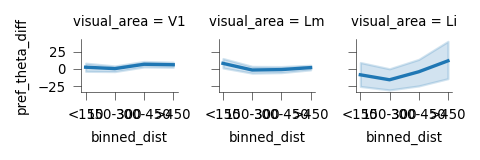

In [1435]:
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=fitdist, height=1)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1436]:
# fitdist['abs_diff_rad'] = [np.deg2rad(i) for i in fitdist['abs_diff'].values]

# fitdist['binned_rad'] = [np.deg2rad(i) for i in fitdist['binned_theta'].values]

# print(fitdist['abs_diff_rad'].min(), fitdist['abs_diff_rad'].max())
# print(fitdist['binned_rad'].min(), fitdist['binned_rad'].max())
# fitdist.head()

In [1437]:
# Mean by FOV
mean_fitdist = fitdist.groupby(
                ['visual_area', 'datakey', 'binned_dist', 'binned_theta'])\
                .mean().reset_index().dropna()
mean_fitdist.head()
# cols = ['visual_area', 'datakey', 'binned_dist', 'binned_rad', 'abs_diff_rad']
# groups = ['visual_area', 'datakey', 'binned_dist', 'binned_rad']
# mean_fitdist = fitdist[cols].groupby(groups)\
#                         .apply(spstats.circmean, 
#                         high=np.pi, low=0, nan_policy='omit').reset_index()\
#                         .rename(columns={0: 'abs_diff_rad'})
# mean_fitdist['abs_diff'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['abs_diff_rad'].values]
# mean_fitdist['binned_theta'] = [np.rad2deg(i) for \
#                                     i in mean_fitdist['binned_rad'].values]

,visual_area,datakey,binned_dist,binned_theta,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,pref_theta_diff,abs_diff
40,Li,20190314_JC070_fov1,<150,-180.0,297.0,318.0,0.050655,0.433490,107.332928,-176.326531,176.326531
41,Li,20190314_JC070_fov1,<150,-140.0,279.0,297.0,-0.149087,-0.083493,107.157176,-154.285714,154.285714
43,Li,20190314_JC070_fov1,<150,-60.0,218.0,253.0,0.293214,0.181292,101.372948,-51.428571,51.428571
44,Li,20190314_JC070_fov1,<150,-20.0,254.0,270.5,0.541135,0.144238,93.358755,-18.367347,18.367347
51,Li,20190314_JC070_fov1,150-300,-140.0,211.0,259.5,-0.128815,0.023185,271.443274,-154.285714,154.285714


In [1438]:
# d_=[]
# for (va, dk, b_dist, b_theta), g in fitdist.groupby(
#         ['visual_area', 'datakey', 'binned_dist', 'binned_theta']):
#     cells_in_bin = np.union1d(g['cell_1'].unique(), g['cell_2'].unique())
#     df_ = pd.DataFrame({'cell': cells_in_bin})
#     df_['visual_area'] = va
#     df_['datakey'] = dk
#     df_['binned_dist'] = b_dist
#     df_['binned_theta'] = b_theta
#     d_.append(df_)
# cells_in_bin = pd.concat(d_)

In [1439]:
# meanfit = fitdist.groupby(
#             ['visual_area', 'datakey', 'binned_dist'])['abs_diff']\
#             .mean().dropna().reset_index()
# meanfit.groupby(['visual_area', 'binned_dist']).mean()

<IPython.core.display.Javascript object>


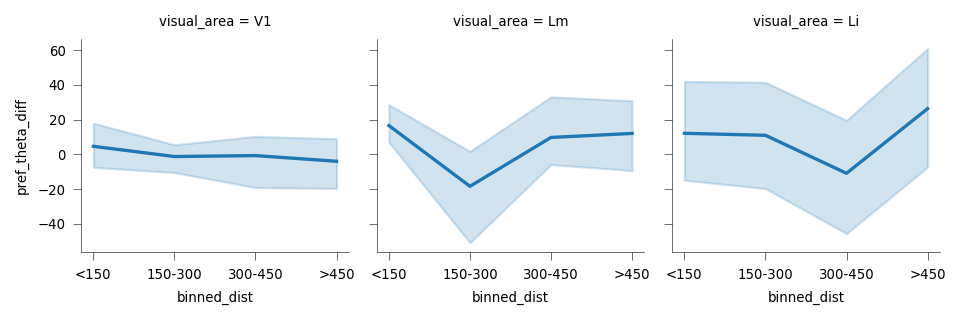

In [1440]:
meanfit = fitdist.groupby(
            ['visual_area', 'datakey', 'binned_dist'])[metric]\
            .mean().dropna().reset_index()
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=meanfit, height=2)
fg.map(sns.lineplot, 'binned_dist', metric)

In [1441]:
counts = fitdist.groupby(['visual_area', 'binned_dist', 'binned_theta'])\
            ['neuron_pair'].count().reset_index()\
        .rename(columns={'neuron_pair': 'n_theta_bin'})
counts
counts['n_dist_bin'] = None
for (va, bd), g in counts.groupby(['visual_area', 'binned_dist']):
    counts.loc[g.index, 'n_dist_bin'] = g['n_theta_bin'].sum()
counts['fraction'] = counts['n_theta_bin'] / counts['n_dist_bin'].astype(float)

<IPython.core.display.Javascript object>


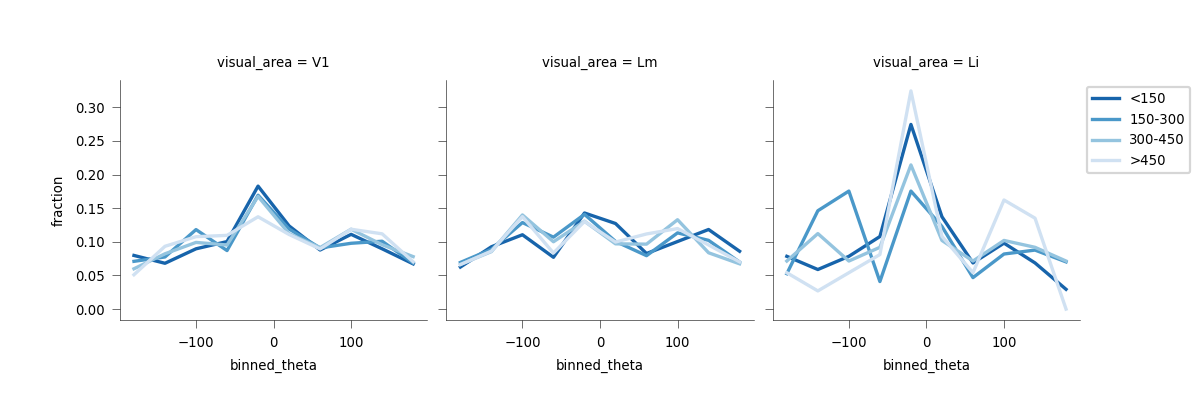

/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())
/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/pandas/io/formats/format.py:1403: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m i

In [1442]:
dist_c = sns.color_palette('Blues_r', n_colors=len(dist_labels))
dist_colors = dict((k, v) for k, v in zip(dist_labels, dist_c))

#{'<150': 'b', '150-300': 'g', '300-450': 'r', '>450': 'k'}
plotd = counts.copy() #[counts['binned_dist']!='>450']
fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, data=plotd,
                  height=2.5)
fg.map(sns.lineplot, 'binned_theta', 'fraction', 'binned_dist',
      palette=dist_colors)

pl.legend(loc='upper left', bbox_to_anchor=(1,1))
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)

<IPython.core.display.Javascript object>


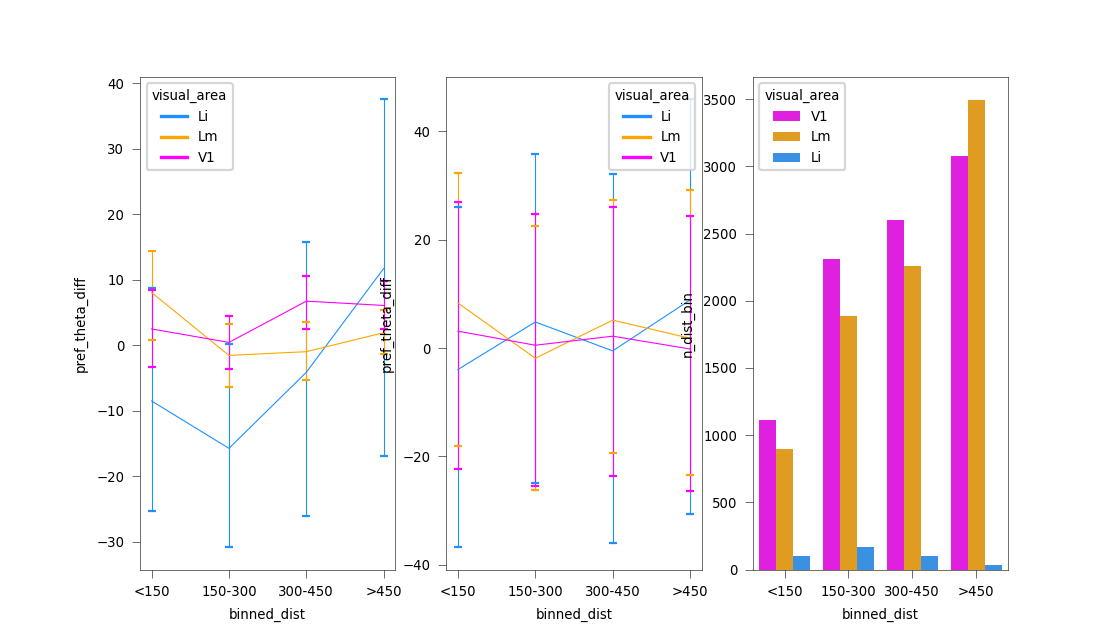

<AxesSubplot:xlabel='binned_dist', ylabel='n_dist_bin'>

In [1443]:
lw=0.5

fig, axn = pl.subplots(1,3,figsize=(7,4)) #, sharex=True, sharey=False)
# metric='abs_diff'
# metric = 'pref_deg_diff'
ax=axn[0]
sns.lineplot(x='binned_dist', y=metric, data=fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[1]
sns.lineplot(x='binned_dist', y=metric, data=mean_fitdist, ax=ax,
             hue='visual_area', palette=area_colors, ci=95,
             err_style='bars', 
             err_kws={'capsize':2, 'lw': lw}, lw=lw)

ax=axn[2]
plotd = counts[['visual_area', 'binned_dist', 'n_dist_bin']].drop_duplicates()
sns.barplot(x='binned_dist', y='n_dist_bin', data=plotd, ax=ax,
           hue='visual_area', palette=area_colors, hue_order=visual_areas)